# Wavelet
这里是对信号理论的教科书《The Wavelete Tour of Signal Processing: The Sparse Way, by Stephane Mallat》的导读。看了不少的材料，最终还是觉得这本书的描述比较全面和深入。其缺陷有两个，其一，是缺少了离散空间算法程序实现的设计与梳理；另外就是没有以自适应性(adaptivity)作为其中一个主要的脉络进行阐述（当然，作者本身可能是默认了自适应性的必要性，因为the spase way就是自适应性的一种系统性的方法）。这两点都可以从另外一本早期关于小波理论的书《Adapted Wavelet Analysis from Theory to Software, by Mladen Victor Wickerhauser》中得到一些补充，尤其是第一点。

总体来说，Mallat的书是关于现代信号处理从理论到实践上非常全面的介绍，而Wickerhauser的书是对算法的程序实现上不可多得的梳理。

这个导读侧重两个方面：
1. 理论上脉络的导读
2. 算法上和一些关键的概念与python的程序包的使用进行对标，其中的程序包包括pywt，scaleogram，scipy.signal等。

如果时间允许的话，我也希望能够对小波算法的程序设计与实现进行有系统的梳理，这里包括基础的算子识别与设计，用软件工程的思路来实现算法，尤其包括online算法。

理论脉络如下：
1. 预备知识
   1. 函数空间$L^2(\mathbb R)$的傅里叶变换：第二章
      - 函数的合成与频率域：2.2.2，3.2.2
      - 函数正则性于频谱分析：2.3.1
   2. Sampling theorem：第三章
      - Shannon-Whittaker离散化原理，定理 3.1，3.2， 其中图3.1展示了离散化的原理。
      - 函数空间$L^2[0,1]$的傅里叶展式。
      - 有限个数信号处理之傅里叶分析
         - 边界处理：定理 3.9 （p. 78），图3.3
         - 快速傅里叶变换 3.3.3, 3.3.4
2. 函数空间$L^2(\mathbb R)$的小波构造
   1. 框架： Mallat 7.1
   2. 生成函数
      - 与conjugate mirror filters(CMF)的关系：定理 7.2
      - 生成函数的选取：Mallat 7.2
   3. 一些小波函数介绍：Mallat 7.3
3. 离散化原理 7.6.1
4. 有限个数信号的处理以及边界问题： 7.5
5. 有限个数信号的快速小波变换： 7.3， 7.5

短期内要完全掌握整个理论脉络是比较困难的。我认为用这些工具进行信号分析必须掌握的基础概念如下：
1. 信号处理的本质
   - 结构分析
   - 特征分类
2. 主要手段：变换的概念
   - 在另外的空间找结构
   - 变换的主要手法：傅里叶与小波分析
   - 变换的主要特征：傅里叶变换引申的频率域，小波的特征是scaling与translation
3. Time-frequency localization(TFL)
   - 傅里叶变换的TFL：window fourier transform
   - 小波的TFL：scaling与频率信息的关系
4. 算法
   - 快速傅里叶变换：概念上了解
   - 快速小波变换：与conjugate mirror filters的关系，熟悉[这里](#coding_wavelet_transform)的实验。
5. 边界处理原理与方法

## Multiresolution analysis
Multiresolution analysis(MRA)是小波研究的框架, 其历史可以参考[Cohen的描述](https://www.degruyter.com/document/doi/10.1515/9781400827268.543/pdf)。

从某种意义上说，小波产生的出发点就是寻找具有time-frequency localization的函数空间中的一组基，这是傅里叶变换的升级版，因为傅里叶变换在获取频率域（frequency)的信息后，丧失了时间上的信息。小波分析就是具有频率域和时间域信息的分析手段。

在MRA之前，小波的研究出现在好几个不同的领域，但缺乏系统性。Mallat总结了前人在这方面的工作，尤其是受到信号处理中[quadrature mirror filter](https://en.wikipedia.org/wiki/Quadrature_mirror_filter)(QMF)研究的启发后，归纳和抽象出MRA这个研究框架。从此，小波的研究步入了有系统的研究发展阶段，目前小波分析已经成为信号处理中成熟的，有严密的理论支撑的核心技术之一。

[MRA](#mra_l2r)的核心技术是generator（性质6）, 也就是产生函数，这个函数所派生出来的一系列子空间必须满足其他五个重要性质。其中性质3是子空间套的概念，性质1和2是子区间套函数的translation和dilation的要求，性质4和5是完备性，即这些子空间套是整个函数空间的一种特殊的空间结构，即由核（$V_0$）开始，往小（空集）和大（整个函数空间）的拉伸结构。

MRA的核心概念是子空间$V_j$是对函数空间的函数在$j$这个"清晰度"的逼近，而且如果用信息量作为测度，$V_j$是$V_{j+1}$的清晰度的2倍。



<a id=mra_l2r></a>
### 函数空间 $L^2(\mathbb R)$
Mallat 7.1.1, Wickerhauser 6.1.3。

A *multiresolution analysis* of $L^2(\mathbb R)$ is a chain of suspaces $\{V_j: j\in\mathbb{Z}\}$ satisfying the following conditions:
1. *Translation invariant*: $v(t)\in V_j\iff v(t-2^jk)\in V_j, \forall j,k\in\mathbb Z$
2. *Dilation*: $v(2t)\in V_{j-1}\iff v(t)\in V_j$;
3. *Containment*: $V_j\subset V_{j-1}\subset L^2$ for all $j\in\mathbb Z$;
4. *Decrease*: $\lim_{j\rightarrow\infty}=0$, i.e., $\cap_{j>N}V_j=\{0\}$ for all $N$;
5. *Increase*: $\lim_{j\rightarrow-\infty}=L^2$, i.e., $\cup_{j<N}V_j=L^2$ for all $N$;
6. *Generator*: There is a function $\phi\in V_0$ whose translates $\{\phi(t-k): k\in\mathbb Z\}$ form a Riesz basis for $V_0$.

**Notice**: From 2 and 6 above, $\phi(2^{-L}t-k),k\in\mathbb Z$ is a Riesz basis for $V_L$. Without loss of generality, we assume that $||\phi||=1$. If $\{\phi(t-k),k\in\mathbb Z\}$ is an orthonormal basis for $V_0$, then the above frame work is called an orthogonal multiresolution analysis.

#### The $H$ operator
From properties 2, 3, and 6, a normalized $\phi$ satisfies a *two-scale equation*:
$$\phi(t)=\sqrt{2}\sum_{k\in\mathbb Z}h(k)\phi(2t-k)\overset{\operatorname{def}}{=}H\phi(t)$$
here $\{h(k)\}$ is a squre-summable sequence of coefficients which defines a linear operator $H$.

#### The $G$ operator
If we define *complementary subspaces* $W_j=V_{j-1}-V_j$ so that $V_{j-1}=V_j+W_j$, then we can telescope the union in the "increase" property to write
$$L^2=\sum_{j\in\mathbb Z}W_j$$
The subspaces $W_j$ are called *wavelet subspaces*, and the equation above is call a wavelet decomposition of $L^2$. $W_0$ has a Riesz basis generated by a function $\psi$ satisfying the *wavelet equation*:
$$\psi(t)=\sqrt{2}\sum_{k\in\mathbb Z}g(k)\phi(2t-k)\triangleq G\phi(t);\quad g(k)=(-1)^k\bar{h}(1-k).$$
The distinguished function $\psi$ is called the *mother wavelet*. If $\phi$ or equivalently $H$ is well-behaved, then $\{\psi(2^{-j}t-k): k\in\mathbb Z\}$ gives a Riesz basis for $W_j$, and $\{2^{-j/2}\psi(2^{-j}t-k): j,k\in\mathbb Z\}$ gives a Riesz basis for $L^2$.

### 函数空间 $L^2[0,1]$


### Sampling Theorem

### Signal with length $2^L$
<a id="conjugate_mirror_filters"></a>
#### Connection with conjugate mirror filters
The term *quadrature filter* is an operator which convolves and then decimates by $2$. Here decimation by $q$ is regarded as the process of discarding all values of a smapled function except those index by a multiple of $q>0$.
A conjugate mirror filter (some people call it quadrature mirror filter) is a pair of quadrature filters with one low pass filter and the other high pass filter.

#### Connection with MRA on $L^2$
1. Start with the signal space $V_0$, that is considering all our signals in this space. A signal with finite number of data points $[x_1,x_2,\cdots,x_N]$ are sampled from some function $f\in V_0$, i.e., $x_i=x(t_i), i=1,2,\cdots,N$.
2. $V_j=V_{j+1}\oplus W_{j+1},\quad \forall j\in[0,1,2,\cdots,L],\quad\textrm{for a given}\ L\in\mathbb{N}$


### 作业
#### Time-frequency localization
1. 设计若干个合成信号来验证傅里叶变换丧失了时间信息。
2. 应用dwt于1的信号，验证小波的time-frequency localization。
3. 展示一个wavelet函数的time-frequency localization。

#### Features extraction and denoising
1. 对上面的合成信号加不同程度的白噪音。
2. 利用fft来去噪音。
3. 利用小波来去噪音。

#### QMF and fast wavelet transform
1. convolution: use two algorithms
2. subsampling
3. obtain qmf from a wavelet
4. perform qmf analysis using 1, 2 and 3, comparing result from pywt.dtw

#### Data streaming
1. reactive programming in python, make a simple publisher and listener system
2. make a time series publishing service, a fft listener and a wavelet listener
3. make the above listeners to publish features, and make two feature listeners to display features, one for fft and the other for wavelet
4. filter bank: make a filter bank application on this data streaming publisher

## Coding

In [1]:
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import scaleogram as scg 
import pywt

from scipy import signal # convolution

In [2]:
# choose default wavelet function for the entire notebook
# here we choose Complex Morlet wavelets
#scg.set_default_wavelet('cmor1-1.5')

### Wavelet functions
#### Query the wavelet family

In [3]:
# list of wavelet families
pywt.families()

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

In [4]:
# list of family with a specific type
pywt.wavelist(kind='continuous')

['cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'mexh',
 'morl',
 'shan']

In [5]:
# list of wavelet functions in a given family
family='db'
print("%s family: " % family + ', '.join(pywt.wavelist(family)))

db family: db1, db2, db3, db4, db5, db6, db7, db8, db9, db10, db11, db12, db13, db14, db15, db16, db17, db18, db19, db20, db21, db22, db23, db24, db25, db26, db27, db28, db29, db30, db31, db32, db33, db34, db35, db36, db37, db38


#### __[Wavelet object](https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html#wavelet-object)__

In [6]:
# creating wavelet object for discrete wavelet
w = pywt.Wavelet('db5')
# wavelet properties
print(w)

Wavelet db5
  Family name:    Daubechies
  Short name:     db
  Filters length: 10
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


In [7]:
[dec_lo, dec_hi, rec_lo, rec_hi]=w.filter_bank

#### __[ContinuousWavelet object](https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html#continuouswavelet-object)__

In [8]:
# creating wavelet object for continuous wavelet
w = pywt.ContinuousWavelet('cmor1-1.5')
print(w)

ContinuousWavelet cmor1-1.5
  Family name:    Complex Morlet wavelets
  Short name:     cmor
  Symmetry:       asymmetric
  DWT:            False
  CWT:            True
  Complex CWT:    True


#### __[Custom wavelets](https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html#custom-wavelets)__

In [9]:
c = math.sqrt(2)/2
dec_lo, dec_hi, rec_lo, rec_hi = [c, c], [-c, c], [c, c], [c, -c]
filter_bank = [dec_lo, dec_hi, rec_lo, rec_hi]
myHaarWavelet = pywt.Wavelet(name="myHaarWavelet", filter_bank=filter_bank)

### Visualizing the wavelet functions
#### Discrete wavelet and scaling functions

In [10]:
wavelet = pywt.Wavelet('db5')
[phi, psi, x] = wavelet.wavefun(level=1)

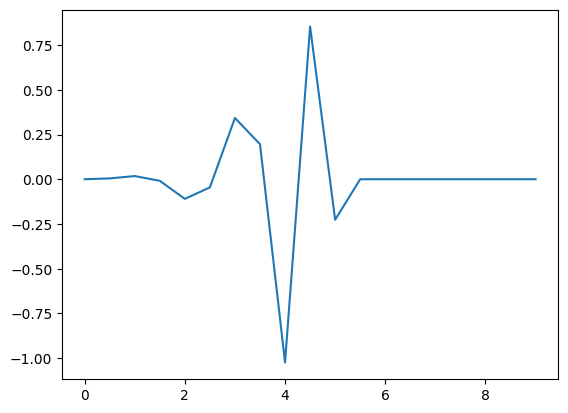

In [11]:
# plotting the wavelet function
plt.plot(x,psi)
plt.show()

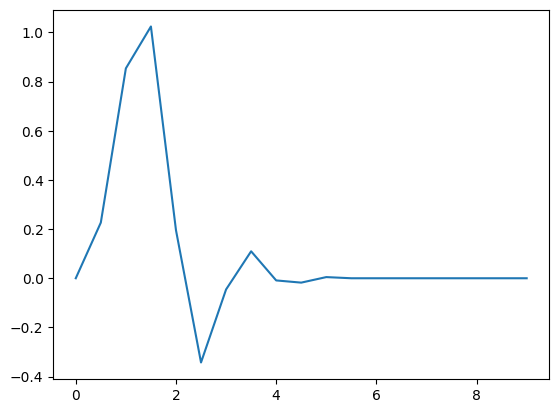

In [12]:
# plotting the scaling function
plt.plot(x,phi)
plt.show()

#### Continuous wavelet functions

In [13]:
w = pywt.ContinuousWavelet('gaus2')
[psi,x] = w.wavefun(level=10)

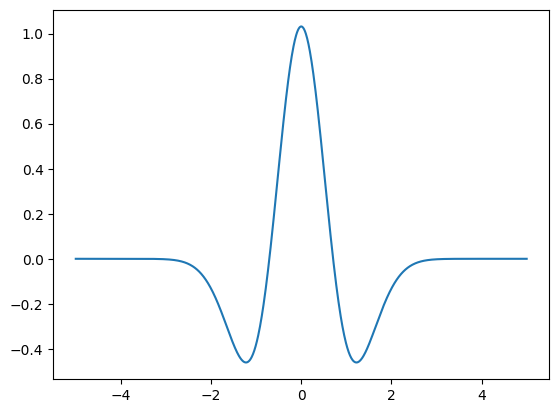

In [14]:
plt.plot(x,psi)
plt.show()

#### Plotting the frequency information

Continuous wavelet will be evaluated over the range [-8.0, 8.0]


Text(0.5, 1.0, '|FFT(filter)|$^2$')

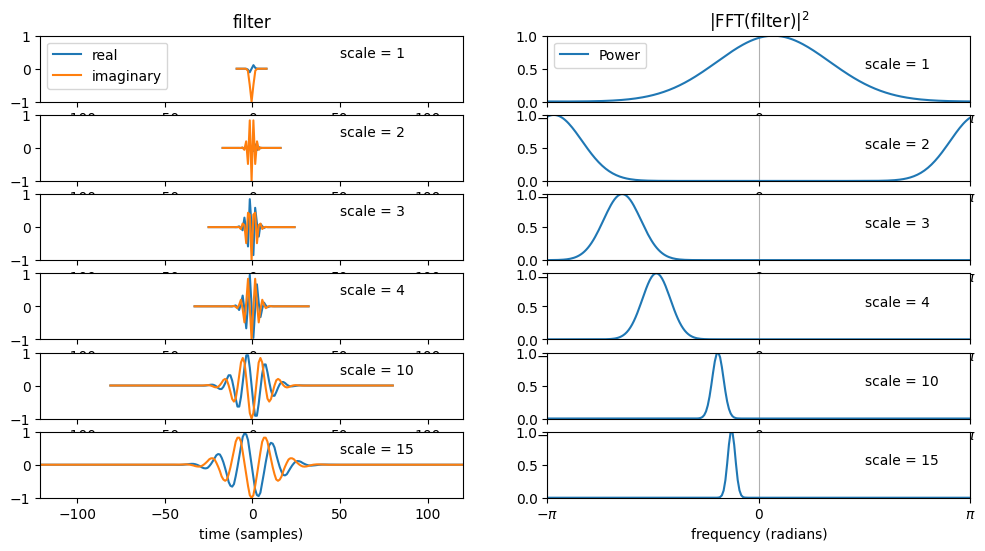

In [15]:
wav = pywt.ContinuousWavelet('cmor1.5-1.0')

# print the range over which the wavelet will be evaluated
print("Continuous wavelet will be evaluated over the range [{}, {}]".format(
    wav.lower_bound, wav.upper_bound))

width = wav.upper_bound - wav.lower_bound

scales = [1, 2, 3, 4, 10, 15]

max_len = int(np.max(scales)*width + 1)
#t = np.arange(max_len)
fig, axes = plt.subplots(len(scales), 2, figsize=(12, 6))
for n, scale in enumerate(scales):

    # The following code is adapted from the internals of cwt
    int_psi, x = pywt.integrate_wavelet(wav, precision=10)
    step = x[1] - x[0]
    j = np.floor(
        np.arange(scale * width + 1) / (scale * step))
    if np.max(j) >= np.size(int_psi):
        j = np.delete(j, np.where((j >= np.size(int_psi)))[0])
    j = j.astype(np.int_)

    # normalize int_psi for easier plotting
    int_psi /= np.abs(int_psi).max()

    # discrete samples of the integrated wavelet
    filt = int_psi[j][::-1]

    # The CWT consists of convolution of filt with the signal at this scale
    # Here we plot this discrete convolution kernel at each scale.

    nt = len(filt)
    t = np.linspace(-nt//2, nt//2, nt)
    axes[n, 0].plot(t, filt.real, t, filt.imag)
    axes[n, 0].set_xlim([-max_len//2, max_len//2])
    axes[n, 0].set_ylim([-1, 1])
    axes[n, 0].text(50, 0.35, 'scale = {}'.format(scale))

    f = np.linspace(-np.pi, np.pi, max_len)
    filt_fft = np.fft.fftshift(np.fft.fft(filt, n=max_len))
    filt_fft /= np.abs(filt_fft).max()
    axes[n, 1].plot(f, np.abs(filt_fft)**2)
    axes[n, 1].set_xlim([-np.pi, np.pi])
    axes[n, 1].set_ylim([0, 1])
    axes[n, 1].set_xticks([-np.pi, 0, np.pi])
    axes[n, 1].set_xticklabels([r'$-\pi$', '0', r'$\pi$'])
    axes[n, 1].grid(True, axis='x')
    axes[n, 1].text(np.pi/2, 0.5, 'scale = {}'.format(scale))

axes[n, 0].set_xlabel('time (samples)')
axes[n, 1].set_xlabel('frequency (radians)')
axes[0, 0].legend(['real', 'imaginary'], loc='upper left')
axes[0, 1].legend(['Power'], loc='upper left')
axes[0, 0].set_title('filter')
axes[0, 1].set_title(r'|FFT(filter)|$^2$')

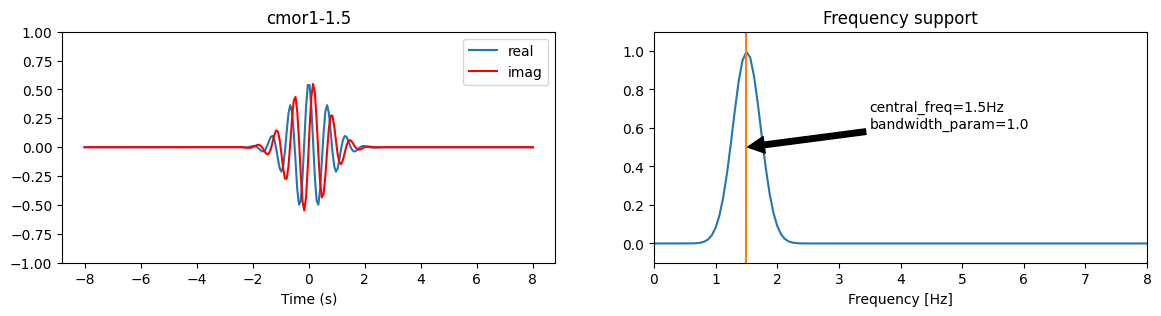

In [16]:
# for continuous wavelet, one can use the package scaleogram to visualize the
# time-frequency information of a mother wavelet
axes = scg.plot_wav('cmor1-1.5', figsize=(14,3))

<a id="coding_wavelet_transform"></a>
### Wavelet transform
#### Using pywt

In [17]:
w = pywt.Wavelet('db5')
mydb5=pywt.Wavelet(name="mydb5", filter_bank=w.filter_bank)
[dec_lo, dec_hi, rec_lo, rec_hi]=w.filter_bank
x = [1,1,1,1,1,1,1,1]
pywt.dwt(x,mydb5)

(array([1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356,
        1.41421356, 1.41421356, 1.41421356]),
 array([-1.69135539e-17, -1.69135539e-17, -1.69135539e-17, -1.69135539e-17,
        -1.69135539e-17, -1.00180281e-16, -7.24247051e-17, -6.54858112e-17]))

In [18]:
pywt.dwt(x,'haar')

(array([1.41421356, 1.41421356, 1.41421356, 1.41421356]),
 array([0., 0., 0., 0.]))

#### Using scipy.signal.convolve
First, let's test the convolve fuction, and build a visualization tool

In [19]:
sig = np.repeat([1., 0.], 100)
win = signal.windows.hann(50)
filtered = signal.convolve(sig, win, mode='same') / sum(win)

In [20]:
def view_convolve(sig_,filter_,conv_):
    fig, (ax_sig, ax_filter, ax_conv) = plt.subplots(3, 1, sharex=True)
    ax_sig.plot(sig_)
    ax_sig.set_title('Analized Signal')
    ax_sig.margins(0, 0.1)
    ax_filter.plot(filter_)
    ax_filter.set_title('Filter')
    ax_filter.margins(0, 0.1)
    ax_conv.plot(conv_)
    ax_conv.set_title('Filtered signal')
    ax_conv.margins(0, 0.1)
    fig.tight_layout()

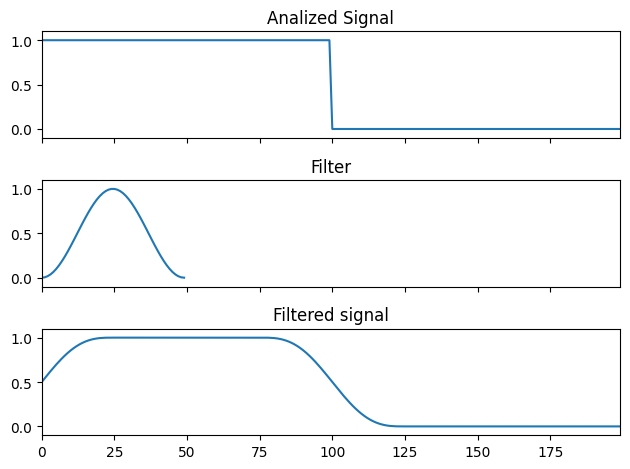

In [21]:
view_convolve(sig,win,filtered)

Next, we get the filters from pywt wavelet object, and perform the convolution operator

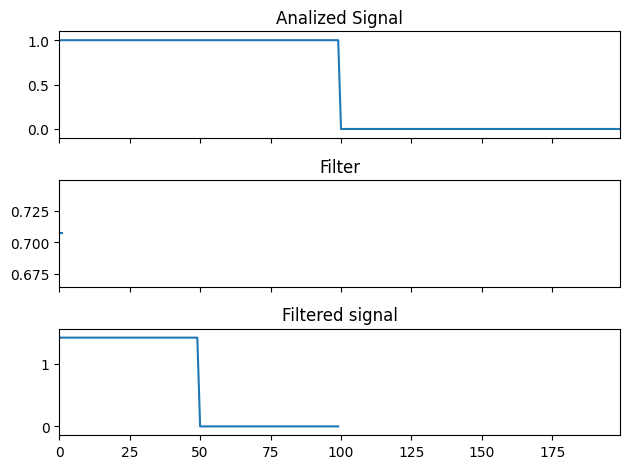

In [22]:
w=pywt.Wavelet('haar')
[dec_lo,dec_hi,rec_lo,rec_hi]=w.filter_bank
cA=np.convolve(sig, dec_lo,mode='valid')[::2]
view_convolve(sig,dec_lo,cA)

Let's compared to the pyw.dwt result

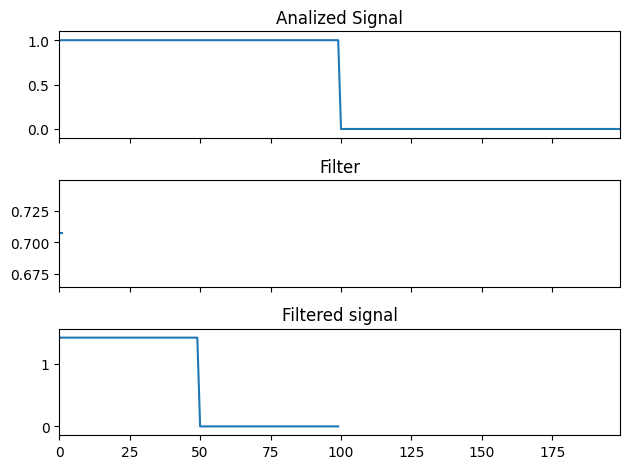

In [23]:
[cApywt,cDpywt]=pywt.dwt(sig,'haar')
view_convolve(sig,dec_lo,cApywt)

In [24]:
np.allclose(cA,cApywt)

True

These looks good, but the following example shows the differences:

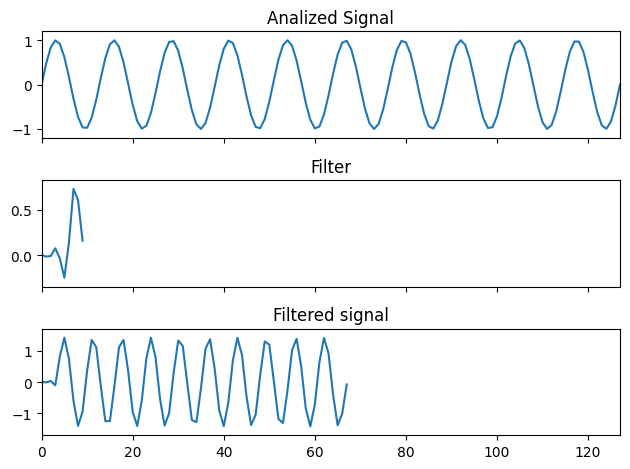

In [25]:
t = np.linspace(0, 1.0, 128)
x = np.sin(2*np.pi*10*t)
w = pywt.Wavelet('db5')
[dec_lo,dec_hi,rec_lo,rec_hi]=w.filter_bank
cA = np.convolve(x, dec_lo)[1::2] 
cD = np.convolve(x, dec_hi)[1::2]
view_convolve(x,dec_lo,cA)

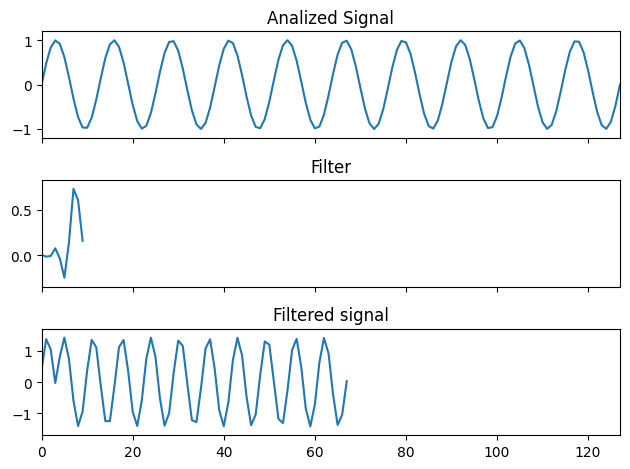

In [26]:
[cApywt,cDpywt]=pywt.dwt(x,w)
view_convolve(x,dec_lo,cApywt)

So, what is going on? Here is what is really happening.

    1. pywt first extends the signal based on padding mode. Default mode is symmetric.
    2. It then performs convolution and returns only the relevant samples for the output.

The convolution is written as part of a C extension. The C extension actually skips computing the convolution for all indices. In other words, it performs convolution and downsampling together by not computing the output for every alternate position.

In [27]:
x_padded = pywt.pad(x, len(dec_lo), 'symmetric')
cApad = np.convolve(x_padded, dec_lo, 'valid')[::2]
cApad = cApad[1:-1]

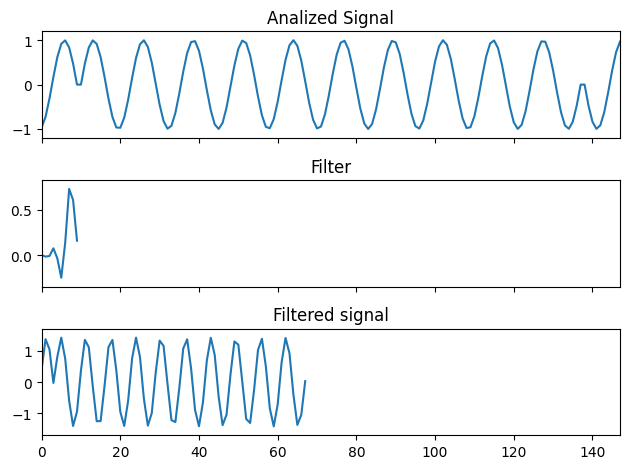

In [28]:
view_convolve(x_padded,dec_lo,cApad)

In [29]:
np.allclose(cApad, cApywt)

True

### Scaleogram
In the wavelet formalism, a scaleogram is a 2D representation of 1D data with    
- On the X axis the time
- On the Y axis the scale<br>
    The scale correspond to the signal frequency information (periodicity) to which the transform is sentitive to.
- The value correspond to the amplitude of the signal variation measured<br>
    These variations are located at time X and have a periodicity Y.

This kind of plot is a special kind of __[spectrogram](https://en.wikipedia.org/wiki/Spectrogram)__, but in the case of wavelet the resolution in time vary with the scale value on the Y axis.